# Kaggle Titanic Survival predictions

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
#read in train and test dataframes
train=pd.read_csv('train.csv')
holdout=pd.read_csv('test.csv')

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
#function to aply all data processing in one go
def all_processing(df):
    final_df=df
    functions=[process_missing, process_age, process_fare, process_titles, process_cabin]
    for f in functions:
        final_df=f(final_df)
    cats=["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]
    for c in cats:
        final_df=create_dummies(final_df, c)
    return final_df

train=all_processing(train)
holdout=all_processing(holdout)

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,0,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,0,0,0,0,1,1,0


## Exploring the SibSp and Parch columns

In [5]:
train['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [6]:
train['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

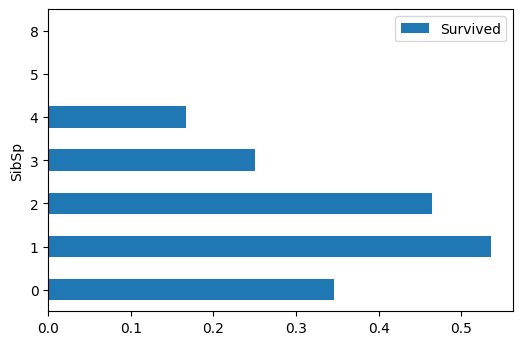

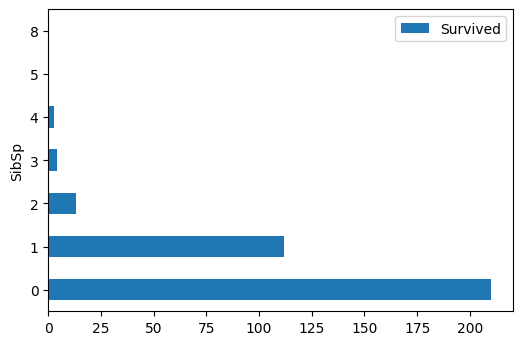

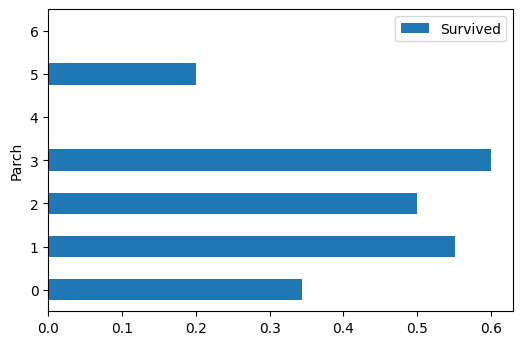

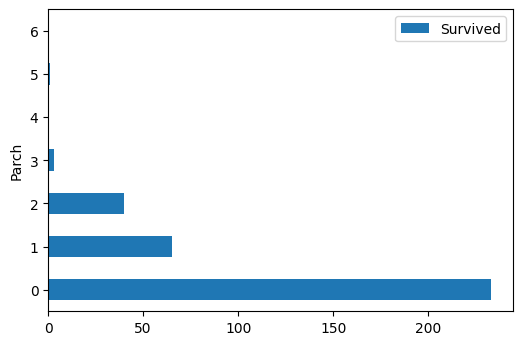

In [7]:
for relative in ['SibSp', 'Parch']:
    meanpv=pd.pivot_table(train, index=[relative], values=['Survived'], aggfunc=np.mean)
    sumpv=pd.pivot_table(train, index=[relative], values=['Survived'], aggfunc=np.sum)

    meanpv.plot(kind='barh')
    sumpv.plot(kind='barh')

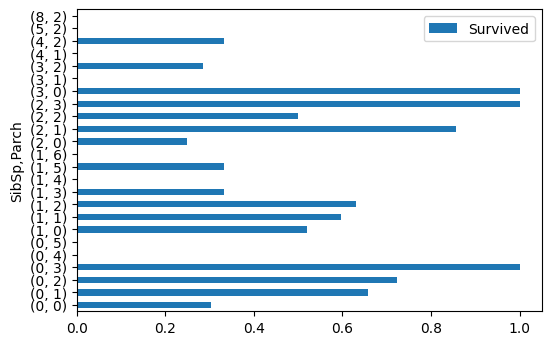

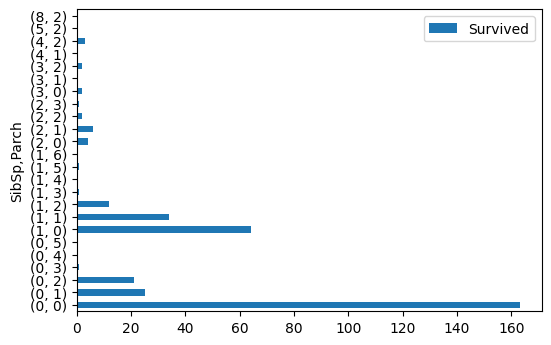

In [8]:
#Combining them, we have the following pivot table
meanpv=pd.pivot_table(train, index=['SibSp', 'Parch'], values=['Survived'], aggfunc=np.mean)
sumpv=pd.pivot_table(train, index=['SibSp', 'Parch'], values=['Survived'], aggfunc=np.sum)

meanpv.plot(kind='barh')
sumpv.plot(kind='barh')


Let us 

We can see that there is an extremely low survival rate of 30% for those with no relatives. This is further significant as the number of people who have no family is 608 out of around 850 passengers.

In [9]:
#familyornot feature
def process_alone(df):
    isalone_bool=(df['SibSp']==0) & (df['Parch']==0)
    df['isalone']=isalone_bool.astype('int')
    return df
train=process_alone(train)
holdout=process_alone(holdout)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,1,0,1,1


## Feature preparation, selection and engineering

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    non_null_df=df.dropna()
    df=non_null_df._get_numeric_data()
    all_X=df.drop(['PassengerId','Survived'], axis=1)
    all_y=df['Survived']
    rf=RandomForestClassifier(random_state=1)
    features=RFECV(rf, cv=10, )
    features.fit(all_X,all_y)
    featbool=features.support_
    return all_X.columns[featbool]

best_features=select_features(train)
print(best_features)
    

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone'],
      dtype='object')


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

models=[{"name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }},
    {
    "name": "LogisticRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
        {
           "solver": ["newton-cg", "lbfgs", "liblinear"]
        }},
    {
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "hyperparameters":
        {"n_estimators": [4, 6, 9],
         "criterion": ["entropy", "gini"],
         "max_depth": [2, 5, 10],
         "max_features": ["log2", "sqrt"],
         "min_samples_leaf": [1, 5, 8],
         "min_samples_split": [2, 3, 5]        
        }}
    ]

def select_model(df, features):
    all_X=df[features]
    all_y=df['Survived']
    for m in models:
        print(m['name'])
        grid=GridSearchCV(m['estimator'], m['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        m['best_model']=grid.best_score_
        m['best_estimator']=grid.best_estimator_
        print(grid.best_estimator_,grid.best_score_)
    return models


models=select_model(train, best_features)
best_models=[(m['best_estimator'],m['best_model']) for m in models]
scores=[m['best_model'] for m in models]
print(scores)


KNeighborsClassifier
KNeighborsClassifier(algorithm='brute', p=1) 0.7767041198501874
LogisticRegression


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

LogisticRegression() 0.8204744069912608
RandomForestClassifier
RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=9) 0.840649188514357
[0.7767041198501874, 0.8204744069912608, 0.840649188514357]


In [16]:
max_index=scores.index(max(scores))
best_estimator_global=best_models[max_index][0]
print(best_estimator_global)

RandomForestClassifier(max_depth=10, max_features='sqrt', n_estimators=9)


In [18]:
def save_submission_file(trained_model, cols, filename='submission.csv'):
    holdout_predictions=trained_model.predict(holdout(cols))
    submission=pd.DataFrame(data={'PassengerId':holdout['PassengerId'],'Survived':holdout_predictions})
    pd.to_csv(submission, filename, index=False)

best_estimator_global.fit(train[best_features], train['Survived'])
save_submission_file(best_estimator_global, best_features)
    
    

TypeError: 'DataFrame' object is not callable